In [1]:
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Importing SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [3]:
# create engine for connecting to hawaii.sqlite db
engine = create_engine("sqlite:///Resources_cleaned/hawaii.sqlite")

In [4]:
# inspecting tables to ensure that they are suitable for further analysis
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Checking data types for measurement table
cols = inspector.get_columns('measurement')
for column in cols:
    print(column['name'], column['type'], column['primary_key'])

measurement_id INTEGER 1
station_id VARCHAR 0
date DATETIME 0
prcp FLOAT 0
tobs INTEGER 0


In [6]:
# Checking data types for station table
cols = inspector.get_columns('station')
for column in cols:
    print(column['name'], column['type'], column['primary_key'])

station_id VARCHAR 1
name VARCHAR 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


### Reflect Database into ORM class and Query

In [7]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Start a session to query the database
session = Session(engine)

In [9]:
Base.classes.keys()

['measurement', 'station']

In [10]:
result = session.query(Station.station_id, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
print(result[0])

('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)


# Precipitation Analysis

In [11]:
#find the latest date in db ## Also unpacking tuple
latest_date, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)


2017-08-23 00:00:00


In [12]:
query_date = latest_date - dt.timedelta(days=365)
print(query_date)

2016-08-23 00:00:00


In [13]:
# Query all dates and prcp values within last one year
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=query_date).all()


In [14]:
# Loading query results in dataframe
df = pd.DataFrame(results, columns=['date','precipitation'])
df = df.sort_values('date',ascending=True)
# df = df.set_index('date')
df.head()

,date,precipitation
0,2016-08-23,0.00
1027,2016-08-23,0.02
702,2016-08-23,0.05
1693,2016-08-23,0.70
359,2016-08-23,0.15


In [15]:
# checkin data types

df.dtypes

date             datetime64[ns]
precipitation           float64
dtype: object

In [16]:
df.count()

date             2021
precipitation    2021
dtype: int64

* Summary Statistics for Precipitation Data

In [17]:
print(df.describe().round(2))

       precipitation
count        2021.00
mean            0.18
std             0.46
min             0.00
25%             0.00
50%             0.02
75%             0.13
max             6.70


To get more sense out of the Plot of precipitation data, I averaged measurement value for each day, so we will end up with one mean precipitation value for each day. 

In [18]:
df_bydate = df.groupby('date').agg(np.mean)
df_bydate.head()

,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


Text(0,0.5,'Precipitation')

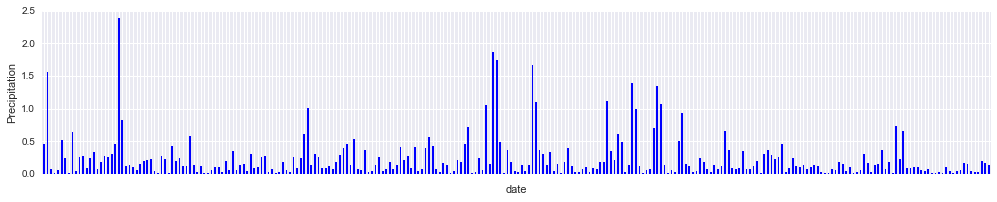

In [19]:
df_test = df_bydate[df_bydate['precipitation']>.01]
fig, ax = plt.subplots(figsize=(17,3))
df_test['precipitation'].plot(kind='bar', ax=ax, color='blue')
ax.set_xticklabels('')
ax.set_ylabel('Precipitation')
# ax.set_xticks()

## Station Analysis


In [20]:
# Checking data types for station table
cols = inspector.get_columns('station')
for column in cols:
    print(column['name'], column['type'], column['primary_key'])

station_id VARCHAR 1
name VARCHAR 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


In [21]:
# Checking data types for measurement table
cols = inspector.get_columns('measurement')
for column in cols:
    print(column['name'], column['type'], column['primary_key'])

measurement_id INTEGER 1
station_id VARCHAR 0
date DATETIME 0
prcp FLOAT 0
tobs INTEGER 0


###### Querying the total number of stations.

In [22]:
# Counting the number of stations
session.query(Station.name).count()


9

###### The Most Active Stations

* listing the stations and observation counts in descending order

In [23]:
session.query(Measurement.station_id ,func.count(Measurement.station_id)).group_by(Measurement.station_id).\
            order_by(func.count(Measurement.station_id).desc()).all()


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

* Station with the highest number of observation

In [24]:
session.query(Station.station_id, Station.name, Station.latitude, Station.longitude, Station.elevation ,func.count(Measurement.station_id)).\
            filter(Measurement.station_id == Station.station_id).group_by(Measurement.station_id).\
            order_by(func.count(Measurement.station_id).desc()).first()


('USC00519281',
 'WAIHEE 837.5, HI US',
 21.45167,
 -157.84888999999995,
 32.9,
 2772)

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.


In [25]:
# query to find tobs for most active station
tob_results = session.query(Measurement.tobs).filter(Measurement.date>=query_date).\
                        filter(Measurement.station_id == 'USC00519281').all()
# print(tob_results,)

In [26]:
# importing query results to df
df_tob = pd.DataFrame(tob_results, columns=['Temperature'])
df_tob.describe()

,Temperature
count,352.000000
mean,73.107955
std,4.733315
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


(0.0, 70)

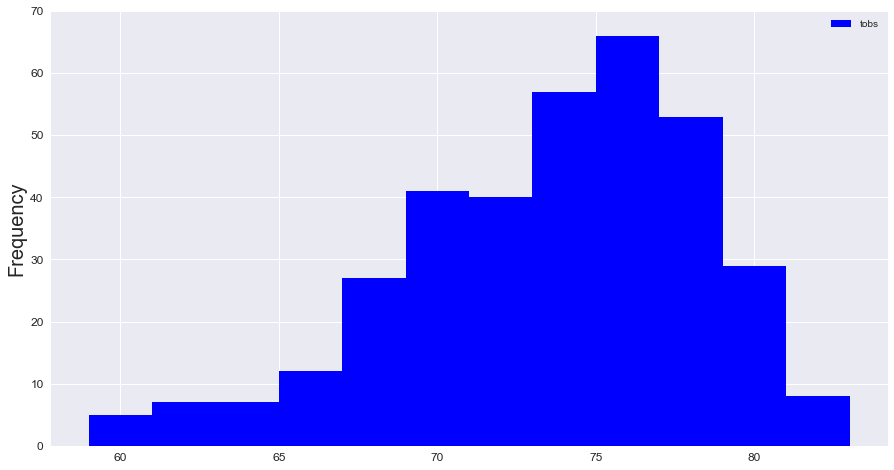

In [27]:
# plotting histogram
bins=[]
fig, ax = plt.subplots(figsize=(15,8))
df_tob.hist(bins=12, ax=ax, color='blue', xlabelsize=12, ylabelsize=12, label='tobs')
ax.set_title('')
ax.legend()
plt.rc('legend', fontsize=25)
ax.set_ylabel('Frequency',fontsize=20)
ax.set_ylim(top=70)


### Temperature Analysis

* Defining a function that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

In [28]:
def calc_temps(start_date, end_date):
    """ Returns the min, avg and max temp for a range of dates
    ARGS: start_date, end_date - A string ("%Y-%m-%d")
    Returns: list of tuples containing min, avg and max temps
    """
    sd = dt.datetime.strptime(start_date, "%Y-%m-%d")
    ed = dt.datetime.strptime(end_date, "%Y-%m-%d")
    result = session.query(Measurement.date, func.max(Measurement.tobs),func.avg(Measurement.tobs),func.min(Measurement.tobs)).\
                filter(Measurement.date>=start_date).filter(Measurement.date<=end_date).group_by(Measurement.date).all()
    return result

* Using the `calc_temps` function to calculate the min, avg, and max temperatures for the trip duration, using dates from an year earlier

In [29]:
trip_start = "2017-01-01"; trip_end = "2017-01-10"
temperatures_trip = calc_temps(trip_start, trip_end)
df_triptemp = pd.DataFrame(temperatures_trip, columns=['Date', 'Max. Temp', 'Mean Temp', 'Min. Temp'])
df_triptemp['Date'] = df_triptemp['Date'].dt.date
df_triptemp = df_triptemp.set_index('Date')
df_triptemp

,Max. Temp,Mean Temp,Min. Temp
Date,,,
2017-01-01,74,68.400000,62
2017-01-02,74,69.200000,66
2017-01-03,71,66.600000,63
2017-01-04,73,67.166667,62
2017-01-05,72,67.500000,63
2017-01-06,74,67.666667,62
2017-01-07,72,70.166667,66
2017-01-08,74,67.666667,60
2017-01-09,77,68.166667,62


* Plotting the bar chart with average value and tmax-tmin as y error bar.

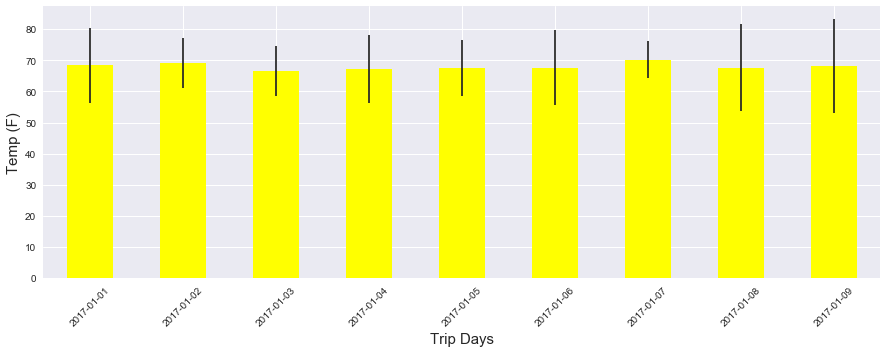

In [30]:
# yerr = [df_triptemp['Max. Temp'].sem(), df_triptemp['Mean Temp'].sem(), df_triptemp['Min. Temp'].sem()]
yerr = df_triptemp['Max. Temp'] - df_triptemp['Min. Temp']
fig, ax = plt.subplots(figsize=(15,5))
df_triptemp['Mean Temp'].plot(kind='bar',color='yellow',yerr=yerr, ax=ax)
ax.set_ylabel('Temp (F)', fontsize=15)
ax.set_xlabel('Trip Days', fontsize=15)

for tick in ax.get_yticklabels():
    tick_setfontsize=12
for value in ax.get_xticklabels():
#     value.
    value.set_fontsize=20
    value.set_rotation(45)

* Calculation of rainfall per weather station using the previous year's matching dates.
    * defining function `calc_rainfall` for calculating total rainfall for every weather station.

In [31]:
def calc_rainfall(start_date, end_date):
    """ Calculating total rainfall for every weather station
    Args:
        start_date(str), end_date(str): date strings in format "%Y-%m-%d"
    Returns:
        A list of tuples containing the stationID and total rainfall
    """
    sd = dt.datetime.strptime(start_date, "%Y-%m-%d")
    ed = dt.datetime.strptime(end_date, "%Y-%m-%d")
    result = session.query(Measurement.station_id, func.sum(Measurement.prcp)).\
                filter(Measurement.date>=start_date).filter(Measurement.date<=end_date).group_by(Measurement.station_id).all()
    return result

In [32]:
trip_start = "2017-01-01"; trip_end = "2017-01-10" # dates one year ago
rainfall_trip = calc_rainfall(trip_start, trip_end)
df_triprainfall = pd.DataFrame(rainfall_trip, columns=['Station_id', 'Total_Rainfall'])
df_triprainfall

,Station_id,Total_Rainfall
0,USC00513117,0.35
1,USC00514830,0.63
2,USC00516128,0.63
3,USC00519281,0.20
4,USC00519397,0.00
5,USC00519523,0.61


* Calculation of the daily normals (Temperatures). Normals are the averages for min, avg, and max temperatures.

  * Creating a function called `daily_normals` that will calculate the daily normals for a specific date. Input date string will be in the format `%m-%d`.

In [33]:
# Creating a function for calculating daily normals
def daily_normals(date):
    """Calculating Daily Normals (temperature)
    Args:
        date(str): A date string in format "%m-%d"
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]    
    daily_normal = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    return daily_normal
    

  * Calculating Normals (temps) during the trip (same dates previous year) using function `daily_normals`.

  


In [34]:
trip_st = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_duration = 9 #days
trip_min=[]; trip_avg=[]; trip_max=[]; trip_date=[]
for day in range(trip_duration):
    date = trip_st + dt.timedelta(days=day)
    date_str = dt.datetime.strftime(date, "%m-%d")
    normals, = daily_normals(date_str)
    trip_min.append(normals[0])
    trip_avg.append(normals[1])
    trip_max.append(normals[2])
    trip_date.append(date_str)
trip_normals = {'Trip_Date':trip_date, 'Min_Temp': trip_min, 'Average_Temp': trip_avg, 'Max_Temp': trip_max}
df_trip_nortemps = pd.DataFrame(trip_normals, columns=['Trip_Date', 'Min_Temp','Average_Temp','Max_Temp'])
df_trip_nortemps = df_trip_nortemps.set_index('Trip_Date')
df_trip_nortemps

,Min_Temp,Average_Temp,Max_Temp
Trip_Date,,,
01-01,62,69.060000,77
01-02,60,69.408163,77
01-03,62,68.833333,77
01-04,58,69.836364,76
01-05,56,68.000000,76
01-06,61,68.886792,76
01-07,57,68.381818,76
01-08,57,67.200000,75
01-09,58,68.072727,78


  * Using Pandas to plot an area plot (`stacked=False`) for the daily normals.
  

Text(0.5,0,'Trip Dates')

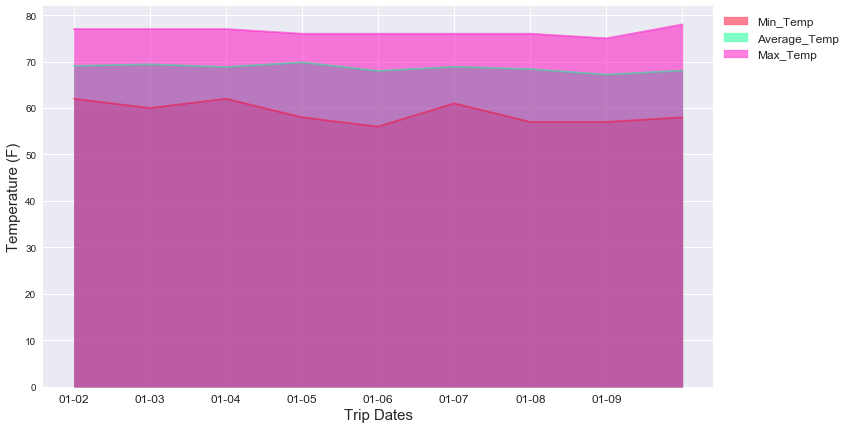

In [35]:
fig, ax = plt.subplots(figsize=(12,7))
df_trip_nortemps.plot(kind='area', ax=ax, stacked=False, alpha=0.5, cmap='gist_rainbow')
ax.legend(bbox_to_anchor = (1,1),loc='best', fontsize='large')
ax.set_xticklabels(labels=df_trip_nortemps.index, fontsize=12)
ax.set_ylabel('Temperature (F)', fontsize=15)
ax.set_xlabel('Trip Dates', fontsize=15)
# ax.fill_between(df_trip_nortemps.index, df_trip_nortemps['Min_Temp'], facecolor='red', alpha=0.5)
# ax.fill_between(x=df_trip_nortemps['Min_Temp'], df_trip_nortemps['Average_Temp'], facecolor='blue', alpha=0.5)
# ax.fill_between(df_trip_nortemps.index, df_trip_nortemps['Max_Temp'], facecolor='black', alpha=0.5)